<a href="https://colab.research.google.com/github/MathewNhari/hello-world/blob/master/Final_Sendy_Logistic_Time_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Importing Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.ensemble import StackingRegressor

#**Importing Data**

In [2]:
riders = pd.read_csv('Riders.csv')
sample = pd.read_csv('SampleSubmission.csv')
test = pd.read_csv('Test.csv')
train = pd.read_csv('Train.csv', parse_dates= ['Placement - Day of Month'])
vd = pd.read_csv('VariableDefinitions.csv')

**Sample Submission**

In [3]:
sample.head()

Order_No  Time from Pickup to Arrival
0  Order_No_19248                        567.0
1  Order_No_12736                       4903.0
2    Order_No_768                       5649.0
3  Order_No_15332                          NaN
4  Order_No_21373                          NaN

In [4]:
riders.head()

Rider Id  No_Of_Orders   Age  Average_Rating  No_of_Ratings
0  Rider_Id_396          2946  2298            14.0           1159
1  Rider_Id_479           360   951            13.5            176
2  Rider_Id_648          1746   821            14.3            466
3  Rider_Id_753           314   980            12.5             75
4  Rider_Id_335           536  1113            13.7            156

In [5]:
train.head()

Order No       User Id  ...      Rider Id  Time from Pickup to Arrival
0   Order_No_4211   User_Id_633  ...  Rider_Id_432                          745
1  Order_No_25375  User_Id_2285  ...  Rider_Id_856                         1993
2   Order_No_1899   User_Id_265  ...  Rider_Id_155                          455
3   Order_No_9336  User_Id_1402  ...  Rider_Id_855                         1341
4  Order_No_27883  User_Id_1737  ...  Rider_Id_770                         1214

[5 rows x 29 columns]

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Order No                                   21201 non-null  object 
 1   User Id                                    21201 non-null  object 
 2   Vehicle Type                               21201 non-null  object 
 3   Platform Type                              21201 non-null  int64  
 4   Personal or Business                       21201 non-null  object 
 5   Placement - Day of Month                   21201 non-null  object 
 6   Placement - Weekday (Mo = 1)               21201 non-null  int64  
 7   Placement - Time                           21201 non-null  object 
 8   Confirmation - Day of Month                21201 non-null  int64  
 9   Confirmation - Weekday (Mo = 1)            21201 non-null  int64  
 10  Confirmation - Time   

In [7]:
#getting the same columns in train as in test data
train_cols = list(train.columns)
test_cols = list(test.columns)
cols = [col for col in train_cols if col in test_cols]
cols.append('Time from Pickup to Arrival')
train =  train[cols]

In [8]:
train.head(1)

Order No      User Id  ...      Rider Id  Time from Pickup to Arrival
0  Order_No_4211  User_Id_633  ...  Rider_Id_432                          745

[1 rows x 26 columns]

# Joining Tables

In [9]:
train = train.merge(riders,on='Rider Id',how='left')
test = test.merge(riders,on='Rider Id',how='left')

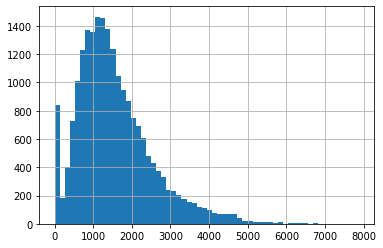

In [10]:
train['Time from Pickup to Arrival'].hist(bins=60)

# **Data Cleaning**

**Seperating Time**

In [11]:
def data_clean(df):
  time_cols = ['Placement - Time','Confirmation - Time','Arrival at Pickup - Time','Pickup - Time']
  
  cat_cols = ['Platform Type','Personal or Business', 'Placement - Weekday (Mo = 1)',
        'Confirmation - Weekday (Mo = 1)','Pickup - Weekday (Mo = 1)','Vehicle Type']
  
  df['Placement - Day of Month'] = df['Placement - Day of Month'].astype('int')
  
  for time in time_cols:
    df[time] = df[time].astype('datetime64')
    df[time+'_hour'] = pd.to_datetime(df[time]).dt.hour
    df[time+'_minutes'] = pd.to_datetime(df[time]).dt.minute
    df[time+'_seconds'] = pd.to_datetime(df[time]).dt.second
  df.drop(time_cols,axis=1, inplace = True)
  
  #get dummy variables
  df = pd.get_dummies(df,columns= cat_cols,drop_first = True)
  cols = ['Precipitation in millimeters','User Id','Rider Id']
  df.drop(cols,axis=1, inplace = True)

  #impute missing data
  imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
  imputer.fit(np.array(df['Temperature']).reshape(-1,1))
  df['Temperature'] = imputer.transform(np.array(df['Temperature']).reshape(-1,1))
  return df
train = data_clean(train)
test = data_clean(test)

# **Feature Engineering**

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 51 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Order No                              21201 non-null  object 
 1   Placement - Day of Month              21201 non-null  int64  
 2   Confirmation - Day of Month           21201 non-null  int64  
 3   Arrival at Pickup - Day of Month      21201 non-null  int64  
 4   Arrival at Pickup - Weekday (Mo = 1)  21201 non-null  int64  
 5   Pickup - Day of Month                 21201 non-null  int64  
 6   Distance (KM)                         21201 non-null  int64  
 7   Temperature                           21201 non-null  float64
 8   Pickup Lat                            21201 non-null  float64
 9   Pickup Long                           21201 non-null  float64
 10  Destination Lat                       21201 non-null  float64
 11  Destination Lon

**Variable Selection by Correlation and Significance**

In [13]:
# Calculate correlations between predictor variables and the response variable
corrs = train.corr()['Time from Pickup to Arrival'].sort_values(ascending=False)

In [14]:
X = train.drop('Time from Pickup to Arrival',axis=1)
feature_corrs = X.corr()

In [15]:
# find rows and columns where correlation coefficients > 0.9 or <-0.9
rows, cols = np.where(np.abs(feature_corrs) > 0.9)

# We are only interested in the off diagonal entries:
off_diagonal = np.where(rows != cols)

# Show the correlation matrix rows and columns where we have highly correlated off diagonal entries:
corr = feature_corrs.iloc[rows[off_diagonal], cols[off_diagonal]]

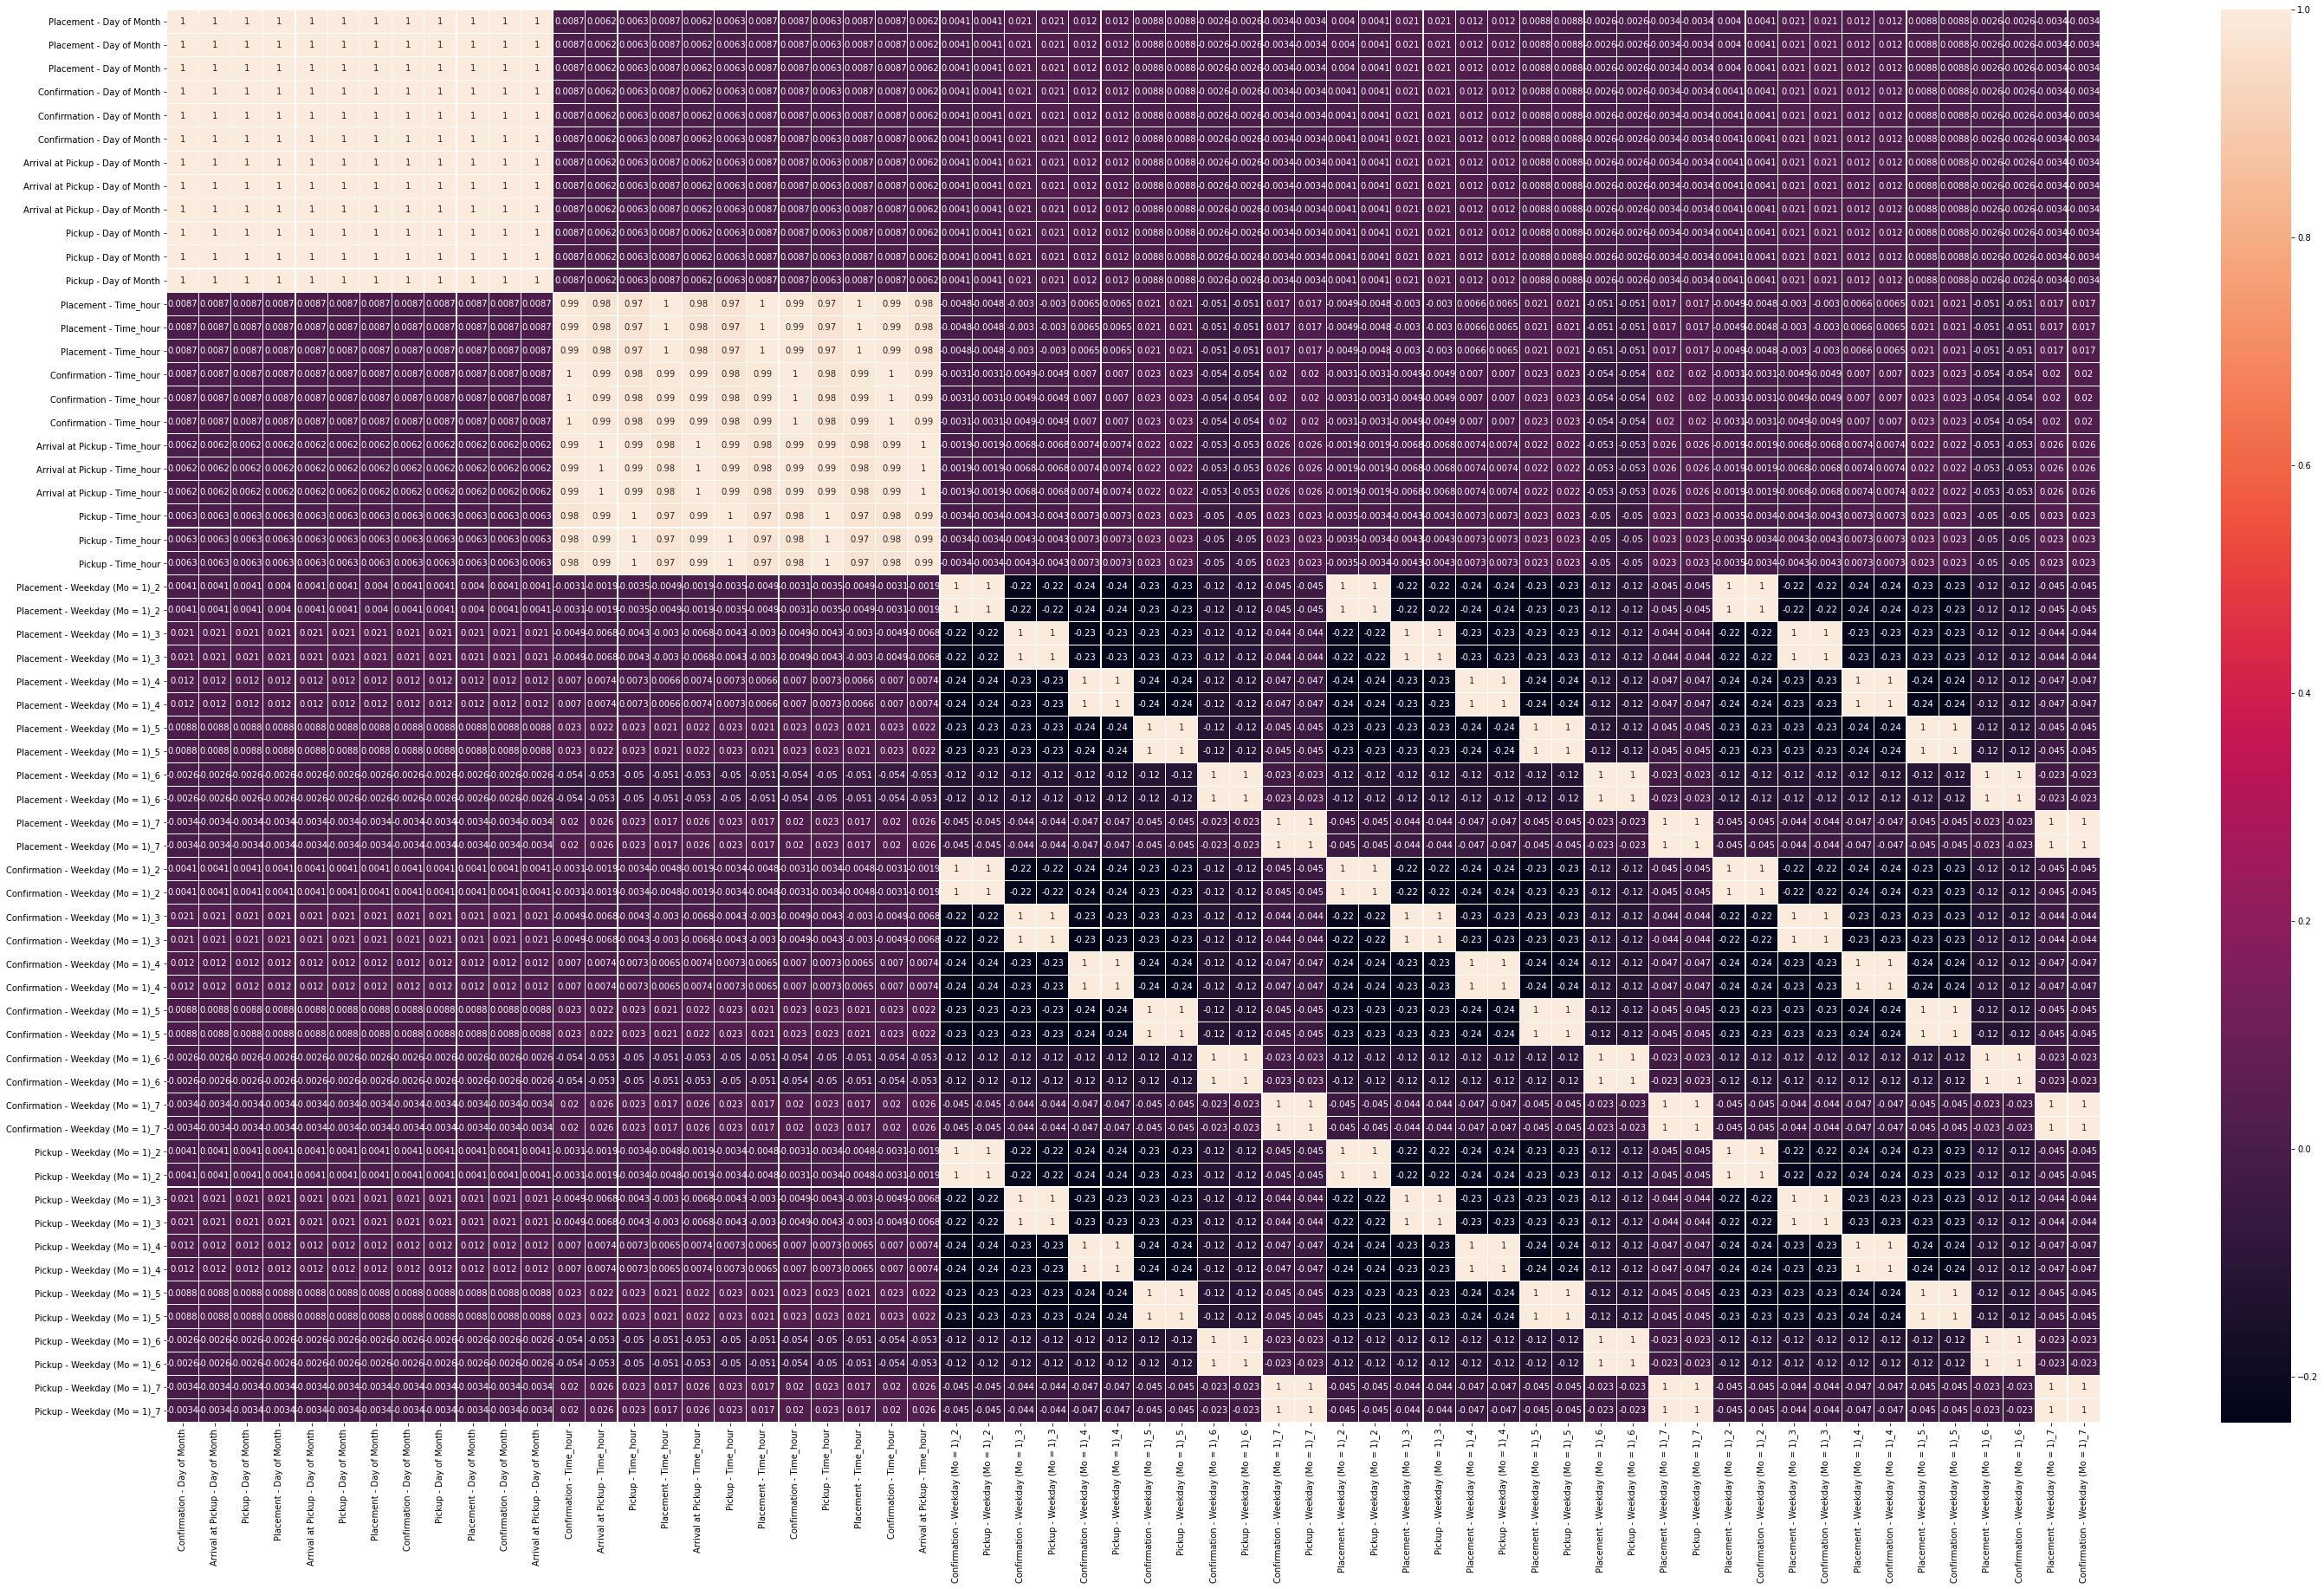

In [16]:
plt.subplots(figsize=(50,30))
sns.heatmap(corr,linewidths=0.1,annot=True)

In [17]:
correlated_features = []
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.8:
            colname = corr.columns[i]
            correlated_features.append(colname)

In [18]:
X = X.drop(correlated_features,axis=1)
X_test = test[X.columns]
y = train['Time from Pickup to Arrival']

# Building Models


In [19]:
#dropping the Order_No column
X = X.drop('Order No',axis=1)
X_test = X_test.drop('Order No',axis=1)

**Feature Scaling**

In [20]:
# create standardization object
scaler_X = StandardScaler()
scaler_y = StandardScaler()

**splitting features into test set and training set**

In [21]:
X_scaled = scaler_X.fit_transform(X)
#y_scaled = scaler_y.fit_transform(np.array(y).reshape(-1,1))

In [22]:
#split dataset into train and test sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled,
                                                    y,
                                                    test_size=0.20,
                                                    random_state=1)

**Ridge Model**

In [23]:
ridge = Ridge()
regressor = LinearRegression()

In [24]:
ridge.fit(X_train, y_train)
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [25]:
ridge_pred = ridge.predict(X_val)
regressor_pred = regressor.predict(X_val)

In [26]:
ridge_rmse = mean_squared_error(y_val, ridge_pred, squared= False)
regressor_rmse = mean_squared_error(y_val, regressor_pred, squared= False)

In [27]:
ridge_rmse

0.8000484839389496

In [28]:
regressor_rmse

0.8000490943637827

Building Decision Tree

In [29]:
reg_tree = DecisionTreeRegressor(max_depth=3)

In [30]:
reg_tree.fit(X_train,y_train)
dt_pred = reg_tree.predict(X_val)

In [31]:
dt_rmse = mean_squared_error(y_val, dt_pred, squared= False)

In [32]:
dt_rmse

0.8037481909047083

SVR Model

In [33]:
sv_reg = SVR(kernel='rbf', gamma='auto')
sv_reg.fit(X_train,y_train)
svr_pred = sv_reg.predict(X_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [34]:
svr_rmse = mean_squared_error(y_val, svr_pred, squared= False)

In [35]:
svr_rmse

0.7951477793149644

Lasso Model

In [36]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_val)

In [37]:
lasso_rmse = mean_squared_error(y_val, y_pred, squared= False)
lasso_rmse

0.8002155261211924

XGBoost model

In [38]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

[15:11:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [39]:
xgb_pred = xgb.predict(X_val)

In [40]:
xgb_rmse = mean_squared_error(y_val, y_pred, squared= False)

In [41]:
xgb_rmse

0.8002155261211924

Stacking method

In [42]:
models = [("DT",reg_tree),("Ridge",ridge),("lasso",lasso),("xgb",xgb),("regressor",regressor),("svr",sv_reg)]

In [43]:
meta_learner_reg = LinearRegression()
s_reg = StackingRegressor(estimators=models, final_estimator=meta_learner_reg)

In [44]:
s_reg.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_stacking.py:642: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[15:11:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:12:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:12:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:12:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:12:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:12:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


StackingRegressor(cv=None,
                  estimators=[('DT',
                               DecisionTreeRegressor(ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=3,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort='deprecated',
                                                     random_state=None,
                                                   

In [45]:
s_reg_pred = s_reg.predict(X_val)

In [46]:
meta_rmse = mean_squared_error(y_val, s_reg_pred, squared= False)

In [47]:
meta_rmse

0.761981267218458

Submission

In [48]:
#Test_data['Arrival at Destination - Day of Month','Arrival at Destination - Weekday (Mo = 1)',
#             'Arrival at Destination - Time']==np.nan

In [50]:
X_test =scaler_X.transform(X_test)

In [53]:
submit_test = s_reg.predict(X_test)

In [54]:
output = pd.DataFrame(submit_test,columns=['Time from Pickup to Arrival'])

In [55]:
output

Time from Pickup to Arrival
0                       -0.176561
1                       -0.247349
2                       -0.221543
3                       -0.434110
4                       -0.322008
...                           ...
7063                     0.007927
7064                     0.995812
7065                     0.195502
7066                     1.039532
7067                     0.087239

[7068 rows x 1 columns]

In [ ]:
Test_data.reset_index(level=0, inplace=True)

In [ ]:
dataset = pd.concat(objs=[Test_data, output], axis=1)

In [ ]:
dataset.head(3)

In [ ]:
submit_DataFrame = dataset[['Order No','Time from Pickup to Arrival']]

In [ ]:
submit_DataFrame

In [ ]:
submit_DataFrame.to_csv('Zindi_Regression_submission.csv', index=False)

In [ ]:
from google.colab import files
files.download('Zindi_Regression_submission.csv')